In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, SimpleRNN, GRU
from tensorflow.keras import regularizers, Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras
from keras import utils

import sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
path = "/content/drive/MyDrive/NeuralNetworks/windpower.csv"

In [ ]:
import pandas as pd
df = pd.read_csv(path,
                 parse_dates=["dt"]).iloc[:50000]
df

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0
...,...,...
49995,2012-06-04 19:45:00,1701.0
49996,2012-06-04 20:00:00,1762.0
49997,2012-06-04 20:15:00,1847.0
49998,2012-06-04 20:30:00,1843.0


In [ ]:
# Dtypes of various columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      50000 non-null  datetime64[ns]
 1   MW      50000 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 781.4 KB


In [ ]:
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by='dt', ascending=True)

In [ ]:
df.set_index('dt', inplace=True)
df.head()

,MW
dt,
2011-01-01 00:00:00,3416.0
2011-01-01 00:15:00,4755.0
2011-01-01 00:30:00,4939.0
2011-01-01 00:45:00,4939.0
2011-01-01 01:00:00,4998.0


In [ ]:
# get the first and last date from the index
first_date = df.index.min().strftime('%Y-%m-%d')
last_date = df.index.max().strftime('%Y-%m-%d')

# combine the dates into a single string
date_range = f"{first_date} to {last_date}"
date_range

'2011-01-01 to 2012-06-04'

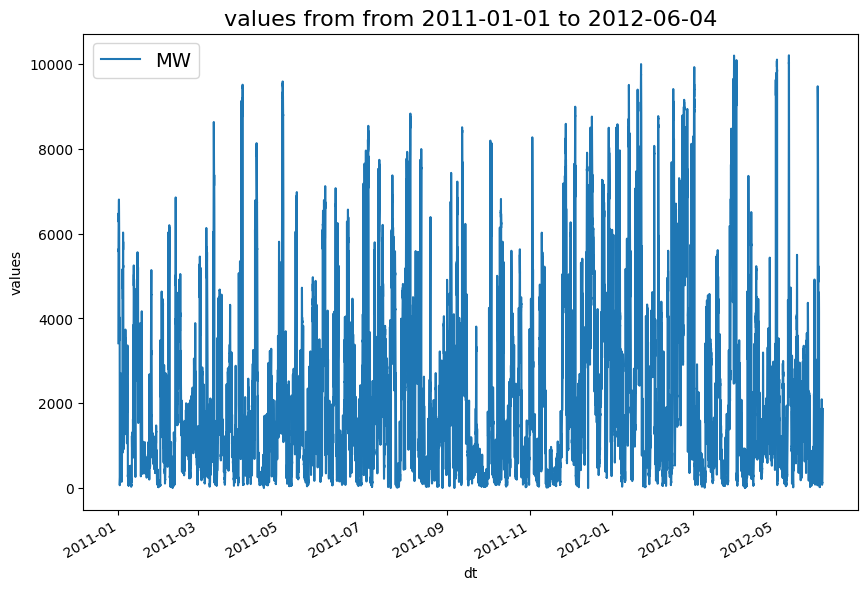

In [ ]:
import matplotlib.pyplot as plt
df.plot(figsize=(10, 7))
plt.ylabel("values")
plt.title(f"values from from {date_range}", fontsize=16)
plt.legend(fontsize=14);

In [ ]:
# Define the split time
split_ratio = 0.8  # 80% for the training set
split_time = int(len(df) * split_ratio)

# Get the train set
time_train = df['dt'].iloc[:split_time]
x_train = df['MW'].iloc[:split_time]

# Get the validation set
time_valid = df['dt'].iloc[split_time:]
x_valid = df['MW'].iloc[split_time:]


In [ ]:
time_train[:2], x_train[:2], time_valid[:2], x_valid[:2]

(0   2011-01-01 00:00:00
 1   2011-01-01 00:15:00
 Name: dt, dtype: datetime64[ns],
 0    3416.0
 1    4755.0
 Name: MW, dtype: float64,
 40000   2012-02-21 16:00:00
 40001   2012-02-21 16:15:00
 Name: dt, dtype: datetime64[ns],
 40000    5278.0
 40001    5362.0
 Name: MW, dtype: float64)

In [ ]:
len(time_train), len(x_train), len(time_valid), len(x_valid),

(40000, 40000, 10000, 10000)

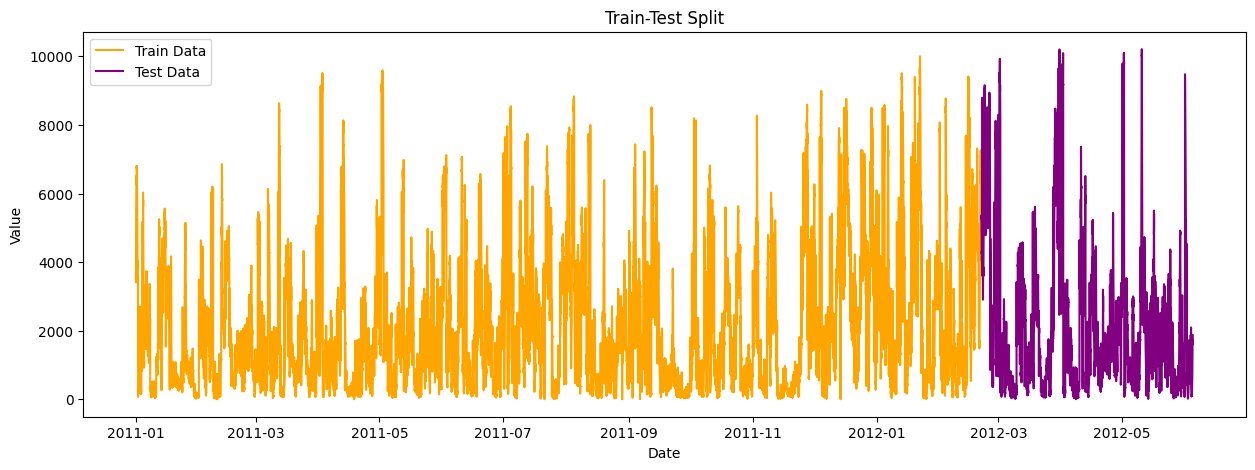

In [ ]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(time_train, x_train, color='orange', label='Train Data')
plt.plot(time_valid, x_valid, color='purple', label='Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
# Parameters
window_size = 7
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# **RNN**

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model_rn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the training parameters


In [ ]:
model_rn.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
# Train the model
history_rn = model_rn.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 51s 39ms/step - loss: 911.4874 - val_loss: 781.5694
Epoch 2/10
1250/1250 [==============================] - 26s 21ms/step - loss: 545.1022 - val_loss: 592.5516
Epoch 3/10
1250/1250 [==============================] - 27s 21ms/step - loss: 394.3986 - val_loss: 464.2535
Epoch 4/10
1250/1250 [==============================] - 27s 22ms/step - loss: 317.5264 - val_loss: 461.0796
Epoch 5/10
1250/1250 [==============================] - 28s 22ms/step - loss: 268.5903 - val_loss: 349.1442
Epoch 6/10
1250/1250 [==============================] - 27s 21ms/step - loss: 237.9586 - val_loss: 315.0747
Epoch 7/10
1250/1250 [==============================] - 27s 21ms/step - loss: 216.7818 - val_loss: 276.0563
Epoch 8/10
1250/1250 [==============================] - 27s 22ms/step - loss: 201.5307 - val_loss: 254.6733
Epoch 9/10
1250/1250 [==============================] - 27s 21ms/step - loss: 190.5519 - val_loss: 237.3799
Epoch 10/10
1250/1250 [=====

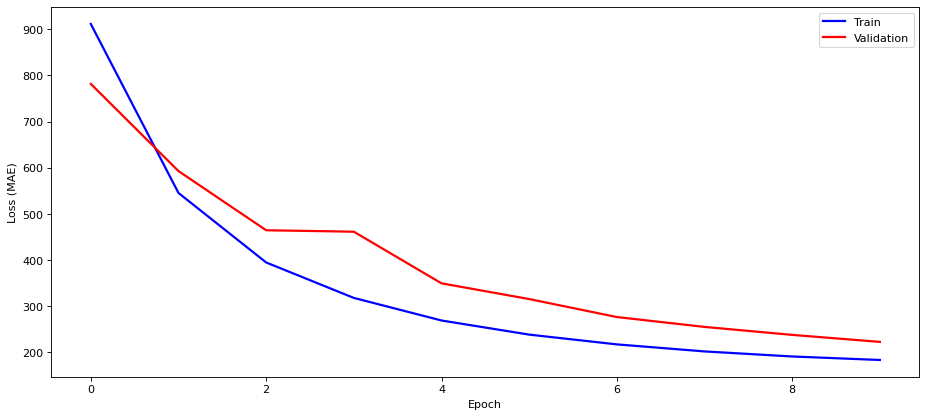

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_rn['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_rn['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Build the model
model_rn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_rn.compile(loss='mae', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4))

In [ ]:
# Train the model
history_rn = model_rn.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 30s 22ms/step - loss: 1415.7988 - val_loss: 1841.2465
Epoch 2/10
1250/1250 [==============================] - 27s 22ms/step - loss: 1419.5812 - val_loss: 1794.5596
Epoch 3/10
1250/1250 [==============================] - 26s 20ms/step - loss: 1416.8240 - val_loss: 1784.9937
Epoch 4/10
1250/1250 [==============================] - 26s 21ms/step - loss: 1418.9570 - val_loss: 1797.8635
Epoch 5/10
1250/1250 [==============================] - 26s 21ms/step - loss: 1418.3126 - val_loss: 1761.1338
Epoch 6/10
1250/1250 [==============================] - 26s 21ms/step - loss: 1419.1707 - val_loss: 1811.4818
Epoch 7/10
1250/1250 [==============================] - 27s 22ms/step - loss: 1420.6250 - val_loss: 1810.0569
Epoch 8/10
1250/1250 [==============================] - 25s 20ms/step - loss: 1419.6006 - val_loss: 1759.7286
Epoch 9/10
1250/1250 [==============================] - 28s 22ms/step - loss: 1416.8566 - val_loss: 1795.5972
Epoch 10/1

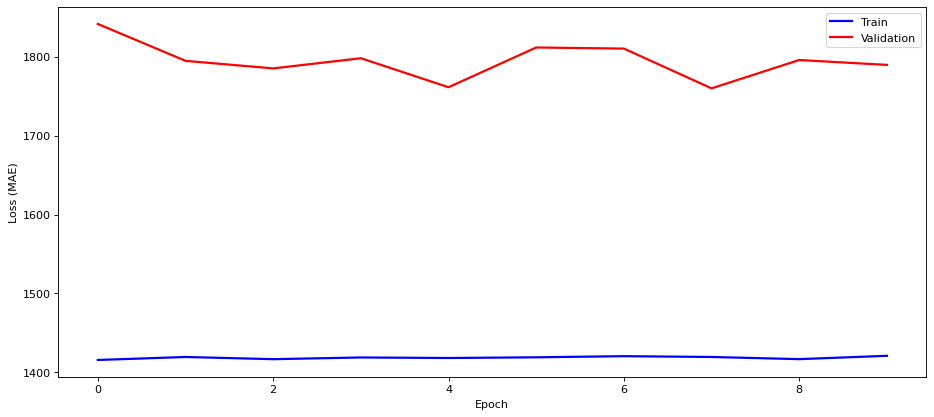

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_rn['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_rn['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Build the model
model_rn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_rn.compile(loss='mae', optimizer=tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-4))

In [ ]:
history_rn = model_rn.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 41s 31ms/step - loss: 1413.2865 - val_loss: 1794.9297
Epoch 2/10
1250/1250 [==============================] - 26s 21ms/step - loss: 1413.3262 - val_loss: 1888.8490
Epoch 3/10
1250/1250 [==============================] - 27s 21ms/step - loss: 1418.3740 - val_loss: 1892.2015
Epoch 4/10
1250/1250 [==============================] - 30s 24ms/step - loss: 1416.2640 - val_loss: 1844.4237
Epoch 5/10
1250/1250 [==============================] - 28s 23ms/step - loss: 1415.7500 - val_loss: 1896.0460
Epoch 6/10
1250/1250 [==============================] - 29s 23ms/step - loss: 1413.8885 - val_loss: 1876.0752
Epoch 7/10
1250/1250 [==============================] - 28s 22ms/step - loss: 1415.2937 - val_loss: 1917.9990
Epoch 8/10
1250/1250 [==============================] - 28s 22ms/step - loss: 1415.1982 - val_loss: 1779.0243
Epoch 9/10
1250/1250 [==============================] - 28s 22ms/step - loss: 1414.8553 - val_loss: 1837.7406
Epoch 10/1

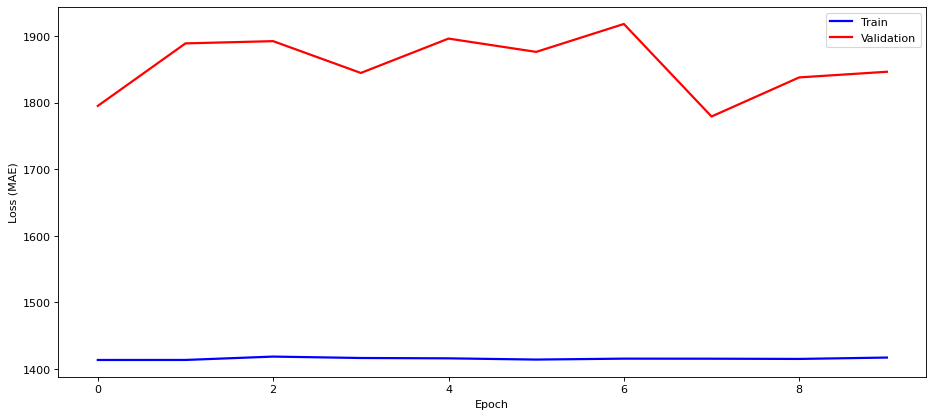

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_rn['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_rn['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Build the model
model_rn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_rn.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4))

In [ ]:
history_rn = model_rn.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 31s 23ms/step - loss: 870.6238 - val_loss: 782.4727
Epoch 2/10
1250/1250 [==============================] - 28s 22ms/step - loss: 535.3803 - val_loss: 604.4910
Epoch 3/10
1250/1250 [==============================] - 28s 23ms/step - loss: 394.0846 - val_loss: 493.2908
Epoch 4/10
1250/1250 [==============================] - 29s 23ms/step - loss: 322.6066 - val_loss: 405.2794
Epoch 5/10
1250/1250 [==============================] - 27s 22ms/step - loss: 281.6136 - val_loss: 411.3339
Epoch 6/10
1250/1250 [==============================] - 27s 21ms/step - loss: 255.1040 - val_loss: 348.4691
Epoch 7/10
1250/1250 [==============================] - 27s 22ms/step - loss: 237.9112 - val_loss: 300.2887
Epoch 8/10
1250/1250 [==============================] - 27s 21ms/step - loss: 223.6962 - val_loss: 347.0493
Epoch 9/10
1250/1250 [==============================] - 27s 22ms/step - loss: 215.0981 - val_loss: 304.6273
Epoch 10/10
1250/1250 [=====

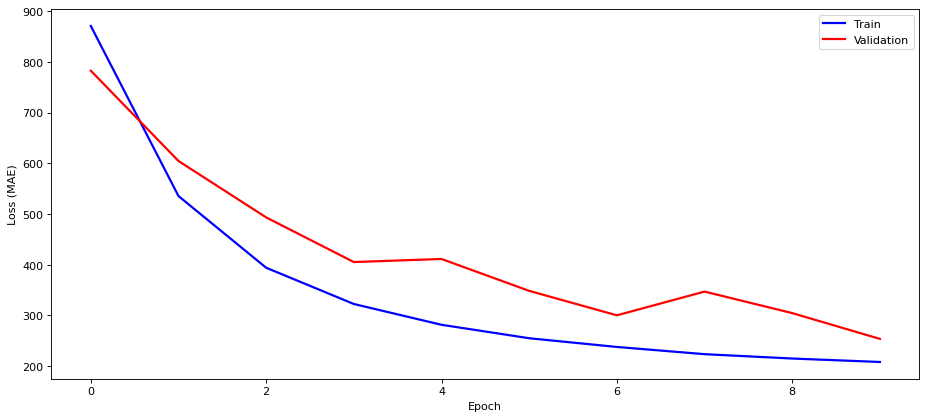

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_rn['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_rn['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()